This notebook is experimenting with two methods of structure optimization: singular value decomposition (SVD) and soft filter pruning (SFP).

The idea of the SVD method is shown in the picture below: the weights of each layer are decomposed into three matrices, then training takes place with additional restrictions on maintaining the orthogonality of the matrices and the sparseness of singular values. After training, the least significant singular numbers and the corresponding rows and columns in orthogonal matrices are pruned. Thus, it is possible to achieve a significant reduction in the number of parameters. During the forward pass, the product of these matrices is calculated, which corresponds to the weight matrix of the original dimension.

![Singular value decomposition](../../docs/img/SVD.png)

The idea of the SVD method is shown in the picture below: after each training epoch, the significance of each filter in the convolutional layer is evaluated, then the least significant filters are set to zero. This procedure is repeated after each training epoch. At the end, unnecessary filters are completely removed from the model.

![Soft filter pruning](../../docs/img/SFP.png)

In [1]:
import sys
sys.path.append('../..')

You can download METU-ALET dataset [here](https://cengmetuedutr-my.sharepoint.com/:u:/g/personal/skalkan_ceng_metu_edu_tr/Ee9IYWHjbWxMrQNuVkuvlU0Buu3DgplFP7BBAWMyG06Qlw?e=z84zLt).
The first step is to prepare the dataset in the pytorch Dataset format.

In [2]:
from torchvision.transforms import ToTensor

from core.architecture.datasets.object_detection_datasets import COCODataset

dataset_path = '/media/n31v/data/datasets/ALET/'

transform = ToTensor()
train_dataset = COCODataset(images_path=f'{dataset_path}train', json_path=f'{dataset_path}train.json', transform=transform)
val_dataset = COCODataset(images_path=f'{dataset_path}val', json_path=f'{dataset_path}val.json', transform=transform)

100%|██████████| 2191/2191 [00:00<00:00, 541814.76it/s]


In the cell below, we define the parameters of the experiments.

If you want to use a pre-trained model, you can set weights parameter like `weights=<your path to state dict>`.

If you don't want to reproduce experiments, you can skip this cell.

In [ ]:
import torch

energy_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999, 1]

exp_params = {
    'dataset_name': 'ALET',
    'train_dataset': train_dataset,
    'val_dataset': val_dataset,
    'num_classes': len(train_dataset.classes) + 1,
    'dataloader_params': {'batch_size': 1, 'num_workers': 2},
    'model_params': {'weights': 'DEFAULT'},
    'models_saving_path': 'models',
    'optimizer': torch.optim.SGD,
    'optimizer_params': {'lr': 0.0002, 'momentum': 0.9, 'weight_decay': 0.0005},
    'scheduler_params': {'step_size': 5, 'gamma': 0.5},
    'metric': 'map_50',
    'summary_path': 'runs',
    'summary_per_class': False,
    'gpu': True
}

In the cell below, we run an experiment without structure optimization for 100 epochs.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")

from core.architecture.experiment.CVModule import FasterRCNNExperimenter


experimenter = FasterRCNNExperimenter(
    structure_optimization='none',
    structure_optimization_params={},
    **exp_params
)
experimenter.fit(100)

In the cell below, we run an experiment with soft filter pruning optimization for 100 epochs.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")

from core.architecture.experiment.CVModule import FasterRCNNExperimenter


experimenter = FasterRCNNExperimenter(
    structure_optimization='SFP',
    structure_optimization_params={
        'pruning_ratio': 0.3,
        'finetuning_epochs': 3
    },
    **exp_params
)
experimenter.fit(100)

In the cells below, we run experiments with a singular value decomposition of convolutional layers for 100 epochs.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")

from core.architecture.experiment.CVModule import FasterRCNNExperimenter


experimenter = FasterRCNNExperimenter(
    structure_optimization='SVD',
    structure_optimization_params={
        'decomposing_mode': 'spatial',
        'orthogonal_loss_factor': 100,
        'hoer_loss_factor': 0.001,
        'energy_thresholds': energy_thresholds,
        'finetuning_epochs': 3
    },
    **exp_params
)
experimenter.fit(100)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")

from core.architecture.experiment.CVModule import FasterRCNNExperimenter


experimenter = FasterRCNNExperimenter(
    structure_optimization='SVD',
    structure_optimization_params={
        'decomposing_mode': 'channel',
        'orthogonal_loss_factor': 100,
        'hoer_loss_factor': 0.001,
        'energy_thresholds': energy_thresholds,
        'finetuning_epochs': 3
    },
    **exp_params
)
experimenter.fit(100)

In [14]:
import pandas as pd
from visualization_utils import parse_experiment_folder

train_scores, svd_scores_finetuned, svd_scores_pruned, sfp_scores = parse_experiment_folder('runs/ALET/FasterR-CNN', sfp=False)

for k in ['val/map', 'val/map_50', 'val/map_75', 'train/loss']:
    train_scores[k].columns = ['Baseline', 'SFP 30%', 'SFP 50%', 'SVD channel', 'SVD spatial']

for k in ['pruning/map_50', 'pruning/size']:
    svd_scores_pruned[k].columns = ['SVD channel', 'SVD spatial']
    svd_scores_finetuned[k].columns = ['SVD channel', 'SVD spatial']

Top models by metrics.

In [15]:
results = pd.DataFrame([train_scores['val/map'].max(axis=0),
                        train_scores['val/map_50'].max(axis=0),
                        train_scores['val/map_75'].max(axis=0)],
                       index=['mAP', 'mAP 50', 'mAP 75']
                       ).T.sort_values('mAP 50', ascending=False)
results

,mAP,mAP 50,mAP 75
Baseline,0.220162,0.419765,0.205151
SVD spatial,0.215009,0.399797,0.211102
SVD channel,0.208874,0.389119,0.203901
SFP 30%,0.190318,0.356599,0.188502
SFP 50%,0.144891,0.312076,0.119684


Run the next cell to visualize the results of the base model, the best sfp model, and the best svd model.

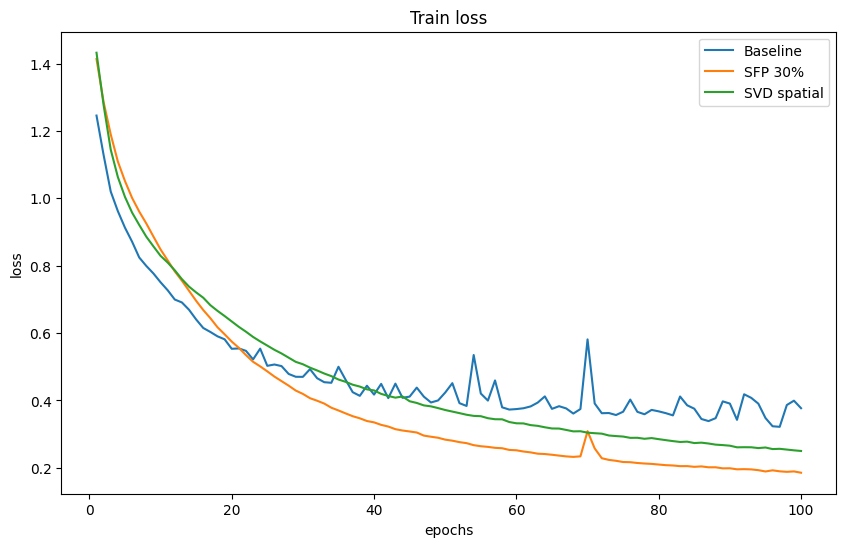

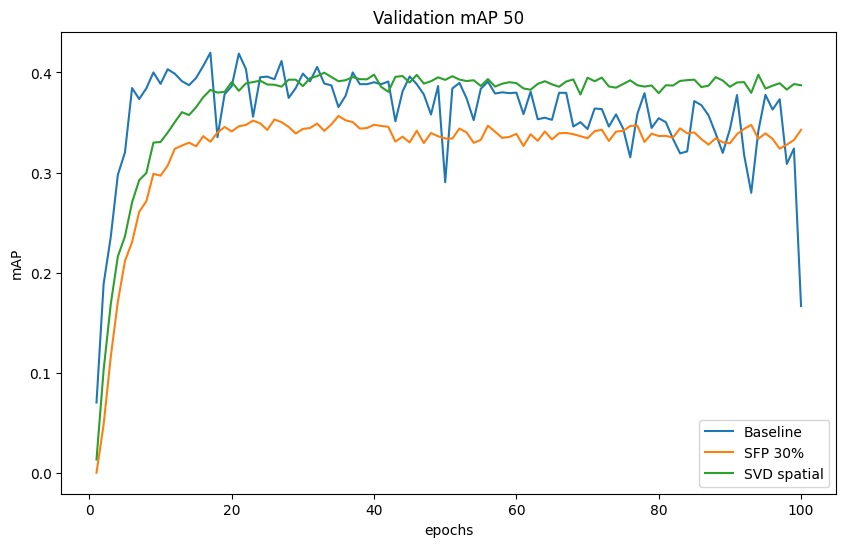

In [18]:
train_scores['train/loss'][['Baseline', 'SFP 30%', 'SVD spatial']].plot(
    figsize=(10, 6),
    title='Train loss',
    xlabel='epochs',
    ylabel='loss'
)
train_scores['val/map_50'][['Baseline', 'SFP 30%', 'SVD spatial']].plot(
    figsize=(10, 6),
    title='Validation mAP 50',
    xlabel='epochs',
    ylabel='mAP'
);

In [19]:
baseline_map = results.loc['Baseline', 'mAP 50']
baseline_size = 166.7

svd_scores_pruned['d_f1'] = (svd_scores_pruned['pruning/map_50'] - baseline_map) / baseline_map * 100
svd_scores_pruned['p_size'] = svd_scores_pruned['pruning/size'] / baseline_size * 100
svd_scores_finetuned['d_f1'] = (svd_scores_finetuned['pruning/map_50'] - baseline_map) / baseline_map * 100
svd_scores_finetuned['p_size'] = svd_scores_finetuned['pruning/size'] / baseline_size * 100

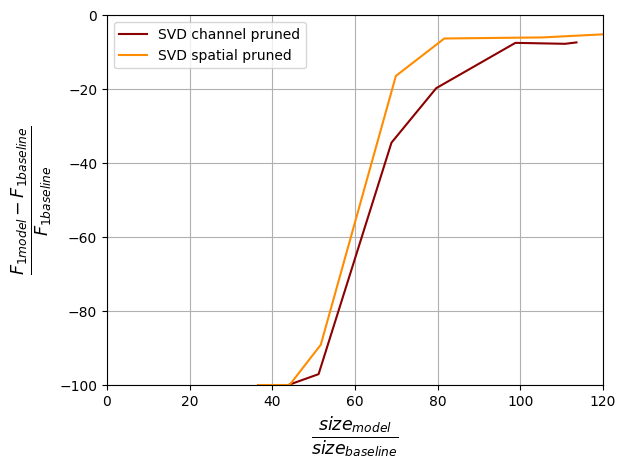

In [25]:
from matplotlib import pyplot as plt
from visualization_utils import plot_scores

plot_scores(
    svd_scores_pruned=(svd_scores_pruned['p_size'], svd_scores_pruned['d_f1'])
)
plt.xlabel('$\\frac{size_{model} }{size_{baseline}}$', fontsize=18)
plt.ylabel('$\\frac{F_{1 model} - F_{1 baseline}}{F_{1 baseline}}$', fontsize=18)
plt.xlim((0, 120))
plt.ylim((-100, 0));